<a href="https://colab.research.google.com/github/Farrukhy/Computer_vision/blob/main/Training_Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow keras keras-cv tensorflow-datasets


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm



Using TensorFlow backend


In [5]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [6]:
BATCH_SIZE = 4

In [7]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]

    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

In [8]:
# https://keras.io/api/keras_cv/bounding_box/formats/#rel_xyxy-class
def unpackage_raw_tfds_inputs(inputs, bounding_box_format):

    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {
        "images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes
    }


In [9]:
def load_pascal_voc(split, dataset, bounding_box_format):

    # Load the dataset with TensorFlow Datasets
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)

    # Map each dataset element to the required format
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(
            x, bounding_box_format=bounding_box_format
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds


In [10]:
# Load the Pascal VOC dataset for training and evaluation
train_ds = load_pascal_voc(
    split="train",
    dataset="voc/2007",
    bounding_box_format="xywh"
)

eval_ds = load_pascal_voc(
    split="test",
    dataset="voc/2007",
    bounding_box_format="xywh"
)

# Shuffle the training dataset
train_ds = train_ds.shuffle(BATCH_SIZE * 4)

In [11]:
print(next(iter(train_ds)))

{'images': <tf.Tensor: shape=(375, 500, 3), dtype=float32, numpy=
array([[[208., 188., 153.],
        [214., 194., 159.],
        [210., 191., 158.],
        ...,
        [187., 142.,  83.],
        [201., 156.,  97.],
        [201., 156.,  97.]],

       [[209., 189., 154.],
        [207., 187., 152.],
        [193., 174., 141.],
        ...,
        [188., 144.,  83.],
        [202., 157.,  98.],
        [204., 160.,  99.]],

       [[208., 188., 151.],
        [206., 186., 149.],
        [207., 189., 153.],
        ...,
        [187., 146.,  82.],
        [202., 161.,  99.],
        [205., 164., 100.]],

       ...,

       [[191., 182., 153.],
        [190., 183., 154.],
        [193., 186., 158.],
        ...,
        [ 88.,  53.,  21.],
        [ 55.,  20.,   0.],
        [ 91.,  56.,  16.]],

       [[188., 181., 153.],
        [185., 180., 151.],
        [189., 183., 157.],
        ...,
        [ 75.,  36.,   5.],
        [ 75.,  35.,   0.],
        [ 98.,  59.,  20.]],

      

In [12]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

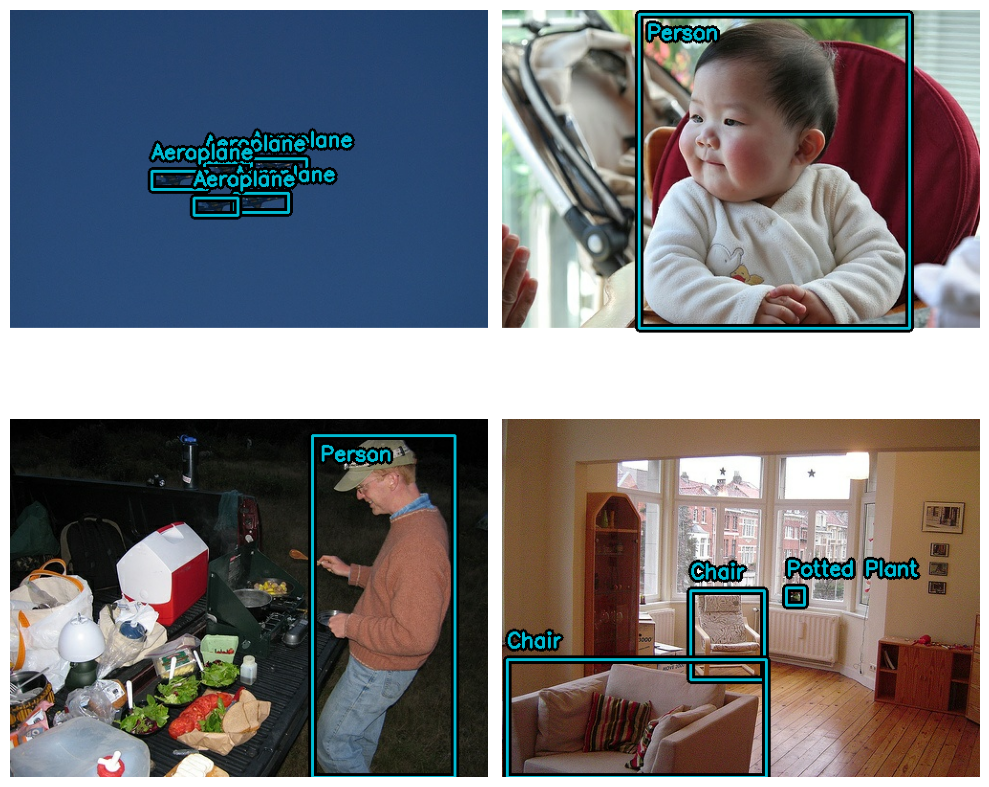

In [13]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

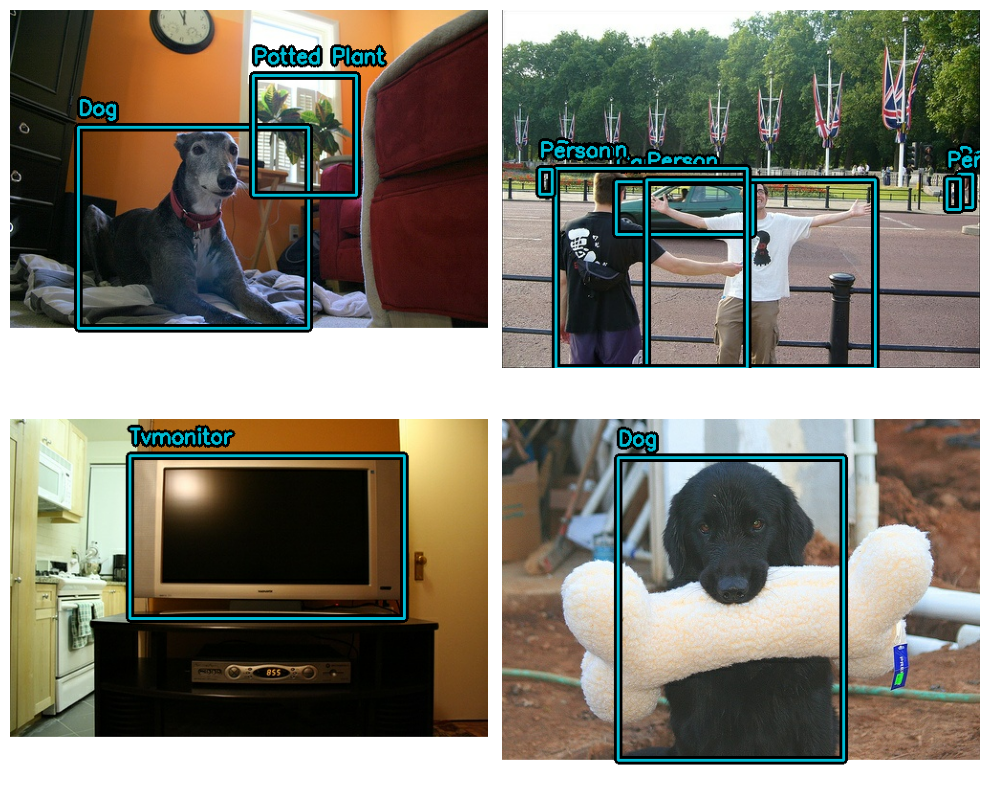

In [14]:
visualize_dataset(
    eval_ds,
    bounding_box_format= "xywh",
    value_range=(0,255),
    rows=2,
    cols=2,
)

In [15]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(
            mode="horizontal",
            bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.75, 1.3),
            bounding_box_format= "xywh"
        ),
    ]
)

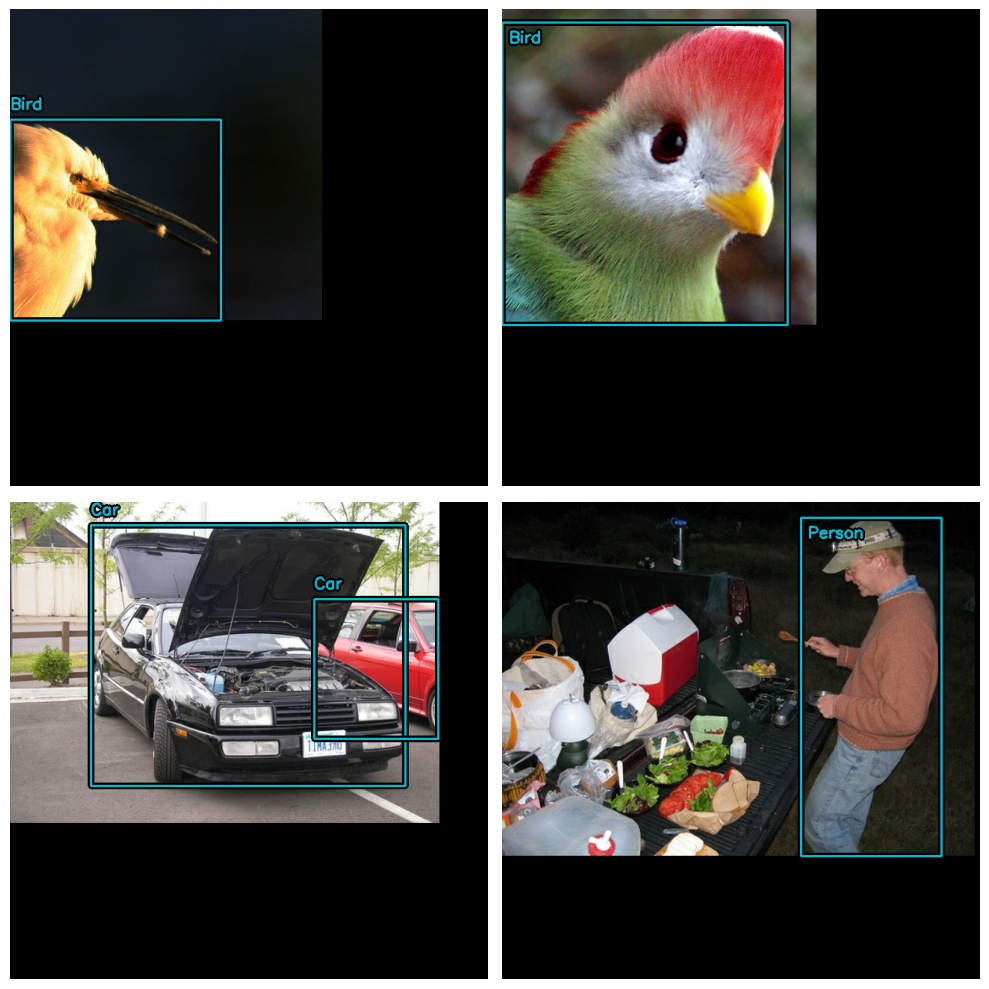

In [16]:
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format='xywh', value_range=(0, 255),rows=2, cols=2
)

In [17]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

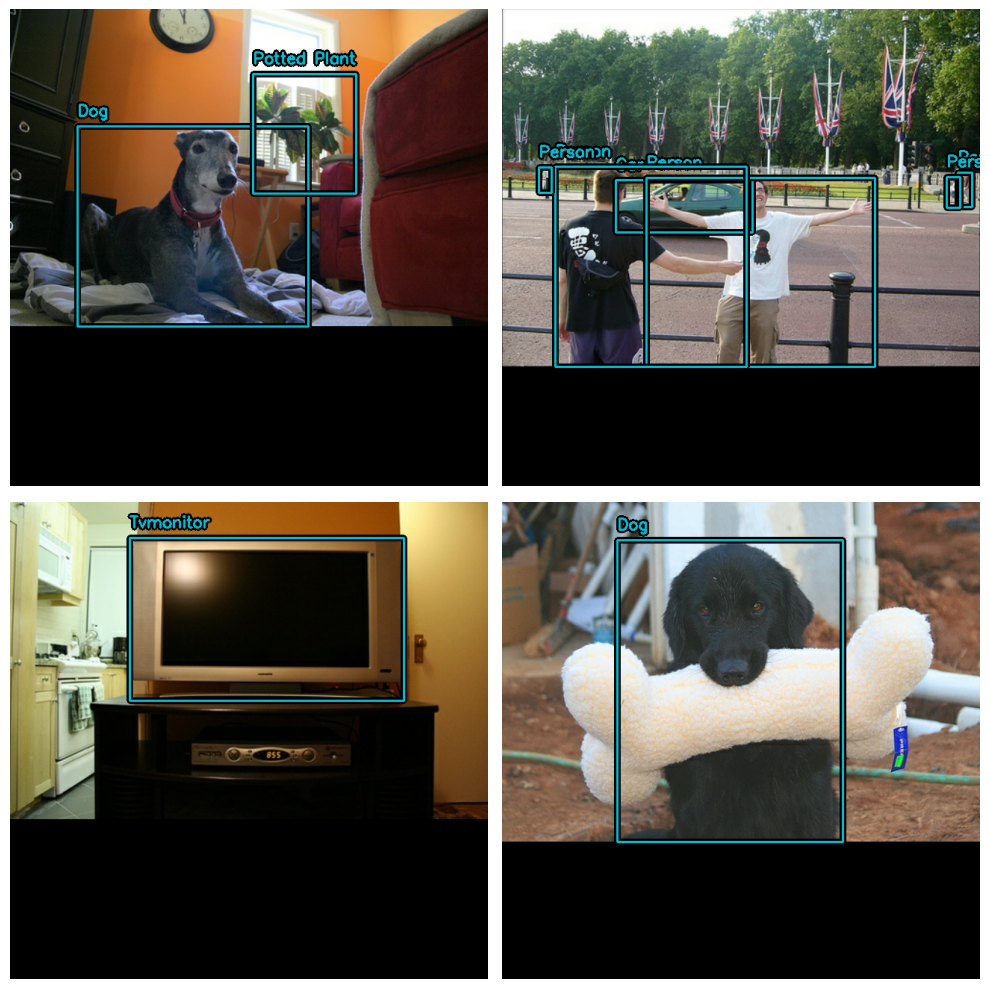

In [18]:
visualize_dataset(
    eval_ds,
    bounding_box_format= "xywh",
    value_range=(0,255),
    rows=2,
    cols=2,
)

In [19]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

In [20]:
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

In [21]:
base_lr = 0.005

optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [22]:
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    bounding_box_format= "xywh",
)

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [23]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
)

In [25]:

model.fit(
    train_ds.take(10),
    validation_data=eval_ds.take(10),
    epochs=2,



)


Epoch 1/2
10/10 [==============================] - 432s 42s/step - loss: 1.6874 - box_loss: 0.6717 - classification_loss: 1.0157 - percent_boxes_matched_with_anchor: 0.9234 - val_loss: 1.6567 - val_box_loss: 0.6816 - val_classification_loss: 0.9752 - val_percent_boxes_matched_with_anchor: 0.9109
Epoch 2/2
10/10 [==============================] - 427s 42s/step - loss: 1.5853 - box_loss: 0.6545 - classification_loss: 0.9308 - percent_boxes_matched_with_anchor: 0.9250 - val_loss: 1.6402 - val_box_loss: 0.6691 - val_classification_loss: 0.9711 - val_percent_boxes_matched_with_anchor: 0.9133


In [26]:
model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc",
    bounding_box_format= "xywh"
)

visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)


100%|██████████| 5.37k/5.37k [00:00<00:00, 6.78MB/s]


100%|██████████| 136M/136M [00:02<00:00, 48.2MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [27]:
def visualize_detections(model, dataset, bounding_box_format):
  images, y_true = next(iter(dataset.take(1)))
  y_pred = model.predict(images)
  y_pred = bounding_box.to_ragged(y_pred)
  visualization.plot_bounding_box_gallery(
      images,
      value_range=(0, 255),
      rows=2,
      cols=4,
      y_true=y_true,
      y_pred=y_pred,
      scale=4,
      font_scale=0.7,
      bounding_box_format=bounding_box_format,
      class_mapping=class_mapping,
      show=True,
  )


In [29]:
model.prediction_decoder= keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format= "xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)


1/1 [==============================] - 23s 23s/step


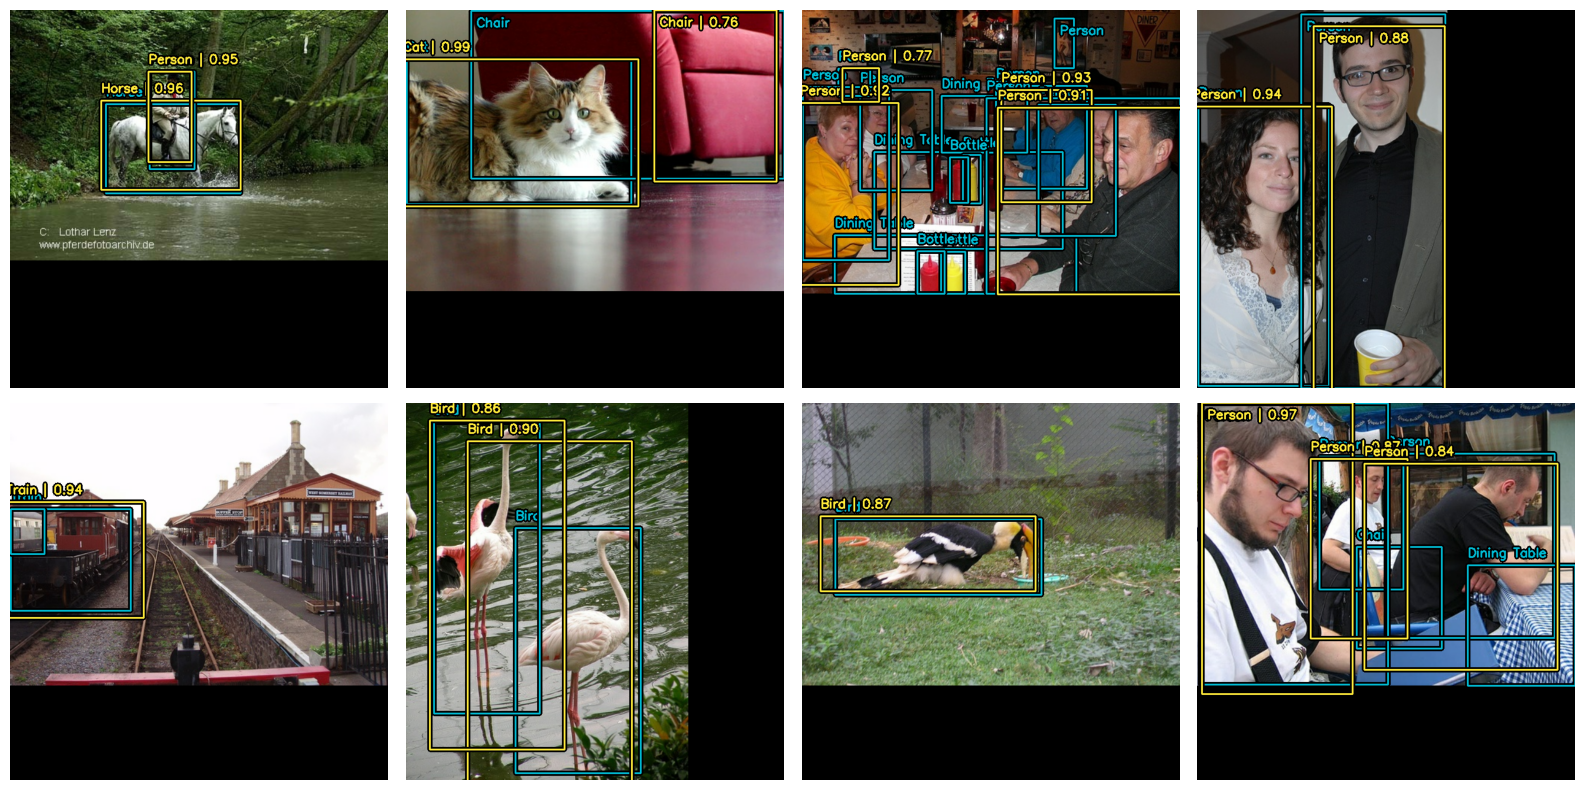

In [30]:
visualize_detections(model, dataset = visualization_ds, bounding_box_format= "xywh")